<a href="https://colab.research.google.com/github/aa14k/adaptive_time/blob/main/code/adaptive_time/notebooks/tradeoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -e code


Obtaining file:///Users/szepi1991/Code/adaptive_time/code
  Installing build dependencies ... - \ | done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... - done
  Installing backend dependencies ... - \ done
  Preparing editable metadata (pyproject.toml) ... - done
  Building editable for adaptive_time (pyproject.toml) ... - done
  Created wheel for adaptive_time: filename=adaptive_time-0.1-0.editable-py3-none-any.whl size=2569 sha256=28588115ccb8ef504bd3e00208b198f2f713980d5ff6bb4de9357eb82478e00a
  Stored in directory: /private/var/folders/xt/69nn93l959l31g_3b686nmsr0000gn/T/pip-ephem-wheel-cache-s8bapjag/wheels/07/43/56/a4aec053025de0632e0ed94a57fc42e37d9d73a60353c313a2
Successfully built adaptive_time
  Attempting uninstall: adaptive_time
    Found existing installation: adaptive_time 0.1
    Uninstalling adaptive_time-0.1:
      Successfully uninstalled adaptive_time-0.1
Note: you may need to restart the kern

In [2]:
# %pip install matplotlib

In [3]:
from importlib import reload

from pprint import pprint

import argparse
import json
import numpy as np

from adaptive_time.environment import MountainCar
from adaptive_time.monte_carlo import mc_policy_iteration
from adaptive_time.samplers import UniformSampler
from adaptive_time.sarsa import sarsa
from adaptive_time.q_functions import MountainCarTileCodingQ
from adaptive_time.utils import parse_dict



In [4]:
import matplotlib.pyplot as plt
import copy

In [5]:
config_file = "code/adaptive_time/configs/sarsa_tilecoding.json"
with open(config_file, "r") as f:
    config_dict = json.load(f)

pprint(config_dict)

{'agent_config': {'action_space': [-1, 0, 1],
                  'iht_size': 4096,
                  'learning_rate': 0.0625,
                  'num_tiles': 8,
                  'num_tilings': 8,
                  'param_init_mean': 0,
                  'param_init_std': 0.0,
                  'q_function': 'tile_coding',
                  'seed': 1,
                  'update_rule': 'sarsa'},
 'budget': 200000,
 'env': 'mountain_car',
 'env_kwargs': {'horizon_sec': 200},
 'log_frequency': 10000,
 'sampler_config': {'sampler': 'uniform', 'sampler_kwargs': {'spacing': 1}},
 'seed': 1}


In [20]:
def setup(config):
  if config.env == "mountain_car":
    q_function = MountainCarTileCodingQ(config.agent_config)
    env = MountainCar(**vars(config.env_kwargs))
  else:
    raise ValueError(f"Unsupported env: {config.env}")

  if config.sampler_config.sampler == "uniform":
      observation_sampler = UniformSampler(
          env.horizon - 1,
          config.sampler_config.sampler_kwargs.spacing,
      )
  else:
      raise NotImplementedError

  return q_function, env, observation_sampler



In [29]:
# config_dict['budget'] = 1000
# config_dict['log_frequency'] = 1000
config_dict['budget'] = 200001
config_dict['log_frequency'] = 50000

sampler_spacing_tries = [100]
# sampler_spacing_tries = [1, 10, 100]
dt_sec = 0.01

results = []
for spacing in sampler_spacing_tries:
  cur_copy = copy.deepcopy(config_dict)
  cur_copy['sampler_config']['sampler_kwargs']['spacing'] = spacing
  cur_copy['env_kwargs']['dt_sec'] = dt_sec
  cur_copy['use_action_repeat'] = True
  config = parse_dict(cur_copy)
  q_function, env, observation_sampler = setup(config)

  np.random.seed(config.seed)
  print()
  print(f"  ::   Starting run with spacing={spacing}   ::  ")

  cum_samples, ep_returns = sarsa(
      env=env,
      q_function=q_function,
      observation_sampler=observation_sampler,
      config=config,
  )

  results.append((cum_samples, ep_returns, f"spacing={spacing}"))



  ::   Starting run with spacing=100   ::  
Sample 0 ====================================
{'curr_tx': {'act': 1,
             'curr_obs': [-0.5, 0.0],
             'done': False,
             'next_obs': array([-5.00000018e-01, -1.76843004e-06]),
             'rew': -1.0},
 'next_q_val': 0.0,
 'next_tx': {'act': 0,
             'curr_obs': array([-5.00000018e-01, -1.76843004e-06]),
             'done': False,
             'next_obs': array([-5.00144481e-01, -2.48214894e-04]),
             'rew': -1.0},
 'param_norms': array([ 0.        , 17.67766953,  0.        ]),
 'q_val': 0.0,
 'target': -100.0,
 'td_error': -100.0,
 'update_norm': 282.842712474619}
Most recent 5 returns: []
Sample 50000 ====================================
{'curr_tx': {'act': 2,
             'curr_obs': [-0.5, 0.0],
             'done': False,
             'next_obs': array([-4.99999918e-01,  8.23156996e-06]),
             'rew': -1.0},
 'next_q_val': -13746.554942898776,
 'next_tx': {'act': 2,
             'curr_

In [30]:
def plot_performance(tuples_of_x_and_y_and_labels, title=None):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for x, y, label in tuples_of_x_and_y_and_labels:
        plt.plot(x, y, label=label)

    # if ylim:
    #     plt.ylim(-0.05, 0.5)
    # ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    # plt.xlim(-1000, 80_000)

    plt.ylabel('Episode\nReturn', rotation=0, labelpad=40)
    plt.xlabel('Number of Samples')
    plt.legend()

    if title is not None:
      plt.title(title)

    plt.show()

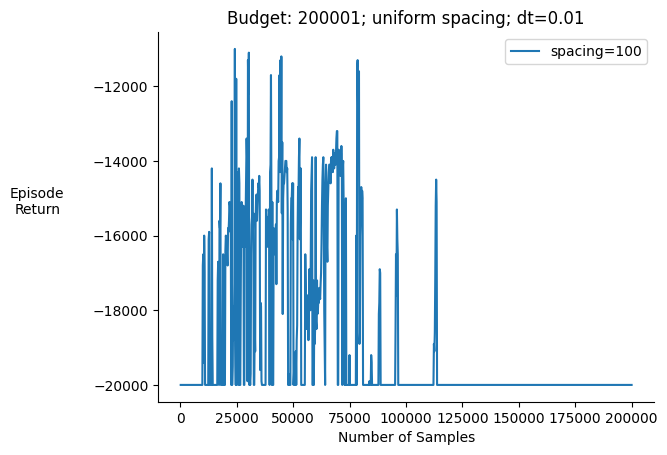

In [31]:
plot_performance(
    results,
    title=f"Budget: {config_dict['budget']}; uniform spacing; dt={dt_sec}")


In [28]:
print(np.mean(results[0][1]))
print(np.mean(results[1][1]))
print(np.mean(results[2][1]))




-19999.0
-19870.43
-18860.569


## Path Figuring Out

In [ ]:
import os
import sys

# Print the working directory
print("Working Directory:", os.getcwd())

# Print the paths for imports
print("Import Paths:")
for path in sys.path:
    print(path)
